# Project in Data Science: 
# Sleep & Productivity Analytics: Patterns and Predictions

Sleep plays a crucial role in overall well-being, yet many people, especially students, struggle 
with maintaining a healthy sleep cycle. Personally, I have experienced sleep issues that have 
negatively affected my mood, stress levels, and daily productivity. This challenge is not unique to 
me, I believe many students face similar problems due to academic pressure, irregular 
schedules, and lifestyle habits.

I have always been interested in how mood and stress are influenced by sleep and daily habits. 
This project allows me to explore these relationships using data-driven insights.

Understanding these connections is important, as poor sleep quality impacts academic 
performance, mental health, and productivity. By analyzing this dataset, I hope to uncover 
insights that can help students and other people improve their well-being.

<hr>

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import re

import lightgbm as lgb

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv("sleep_cycle_productivity.csv")

<hr>

## Data overview

In [3]:
display(data.head())

,Date,Person_ID,Age,Gender,Sleep Start Time,Sleep End Time,Total Sleep Hours,Sleep Quality,Exercise (mins/day),Caffeine Intake (mg),Screen Time Before Bed (mins),Work Hours (hrs/day),Productivity Score,Mood Score,Stress Level
0,2024-04-12,1860,32,Other,23.33,4.61,5.28,3,86,87,116,8.808920,8,3,6
1,2024-11-04,1769,41,Female,21.02,2.43,5.41,5,32,21,88,6.329833,10,3,7
2,2024-08-31,2528,20,Male,22.10,3.45,5.35,7,17,88,59,8.506306,10,9,10
3,2024-02-22,8041,37,Other,23.10,6.65,7.55,8,46,34,80,6.070240,8,4,2
4,2024-02-23,4843,46,Other,21.42,4.17,6.75,10,61,269,94,11.374994,8,7,9


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date                           5000 non-null   object 
 1   Person_ID                      5000 non-null   int64  
 2   Age                            5000 non-null   int64  
 3   Gender                         5000 non-null   object 
 4   Sleep Start Time               5000 non-null   float64
 5   Sleep End Time                 5000 non-null   float64
 6   Total Sleep Hours              5000 non-null   float64
 7   Sleep Quality                  5000 non-null   int64  
 8   Exercise (mins/day)            5000 non-null   int64  
 9   Caffeine Intake (mg)           5000 non-null   int64  
 10  Screen Time Before Bed (mins)  5000 non-null   int64  
 11  Work Hours (hrs/day)           5000 non-null   float64
 12  Productivity Score             5000 non-null   i

<hr>

## Data preprocessing

There is no much data preprocessing needed, but I would rename columns and convert `date` to appropriate data type

In [5]:
# columns rename 
data = data.rename(columns={'Date':'date', 
                            'Person_ID':'id', 
                            'Age':'age', 
                            'Gender':'gender', 
                            'Sleep Start Time':'sleep_start', 
                            'Sleep End Time':'sleep_end', 
                            'Total Sleep Hours':'total_sleep', 
                            'Sleep Quality':'sleep_quality', 
                            'Exercise (mins/day)':'exercise_time', 
                            'Caffeine Intake (mg)':'caffeine', 
                            'Screen Time Before Bed (mins)':'screen_time_before_bed', 
                            'Work Hours (hrs/day)':'work_hours',
                            'Productivity Score':'productivity_score', 
                            'Mood Score':'mood_score', 
                            'Stress Level':'stress_score'}) 

In [6]:
# convert column date to datetime type
data['date'] = pd.to_datetime(data['date'])

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    5000 non-null   datetime64[ns]
 1   id                      5000 non-null   int64         
 2   age                     5000 non-null   int64         
 3   gender                  5000 non-null   object        
 4   sleep_start             5000 non-null   float64       
 5   sleep_end               5000 non-null   float64       
 6   total_sleep             5000 non-null   float64       
 7   sleep_quality           5000 non-null   int64         
 8   exercise_time           5000 non-null   int64         
 9   caffeine                5000 non-null   int64         
 10  screen_time_before_bed  5000 non-null   int64         
 11  work_hours              5000 non-null   float64       
 12  productivity_score      5000 non-null   int64   

<hr>

## Exploratory Data Analysis (EDA)

### Summary statistics

In [8]:
display(data.describe())

,date,id,age,sleep_start,sleep_end,total_sleep,sleep_quality,exercise_time,caffeine,screen_time_before_bed,work_hours,productivity_score,mood_score,stress_score
count,5000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2024-07-03 23:53:05.280000,5527.152200,38.590600,22.005350,4.980262,6.974902,5.520800,43.962600,146.71140,91.421200,7.987873,5.644200,5.370600,5.548000
min,2024-01-01 00:00:00,1000.000000,18.000000,20.000000,0.560000,4.500000,1.000000,0.000000,0.00000,0.000000,4.000067,1.000000,1.000000,1.000000
25%,2024-04-06 00:00:00,3258.000000,28.000000,21.020000,3.660000,5.690000,3.000000,22.000000,73.00000,46.000000,6.032720,3.000000,3.000000,3.000000
50%,2024-07-05 00:00:00,5603.000000,39.000000,22.020000,4.970000,6.960000,5.000000,44.000000,144.00000,92.000000,7.998295,6.000000,5.000000,6.000000
75%,2024-10-05 00:00:00,7749.500000,49.000000,23.000000,6.310000,8.210000,8.000000,66.000000,220.00000,136.000000,9.905024,8.000000,8.000000,8.000000
max,2024-12-31 00:00:00,9998.000000,59.000000,23.980000,9.420000,9.500000,10.000000,89.000000,299.00000,179.000000,11.999141,10.000000,10.000000,10.000000
std,NaN,2595.391771,12.302799,1.157591,1.862508,1.454033,2.863845,25.798541,85.83139,52.079123,2.275734,2.872221,2.835783,2.888419


<hr>

### Duplicates & null values 
As we can see, our data doesn't contain any duplicates or NaN values 

In [9]:
# sum of duplicates
display("Number of duplicates: " + str(data.duplicated().sum()))

# count of null values 
display("count of NULL values:")
display(data.isnull().sum())

'Number of duplicates: 0'

'count of NULL values:'

date                      0
id                        0
age                       0
gender                    0
sleep_start               0
sleep_end                 0
total_sleep               0
sleep_quality             0
exercise_time             0
caffeine                  0
screen_time_before_bed    0
work_hours                0
productivity_score        0
mood_score                0
stress_score              0
dtype: int64

<hr>

### Outliers

This code identifies outliers utilize the <b>1.5 * IQR method</b>, filtering values that fall <b>below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR</b>. It loops through selected columns <b>(excluding 'date', 'id', and 'gender')</b> to detect and display outliers.

In [10]:
# function for finding outliers in particular column
def detect_outliers(data, column):
    # 1st and 3rd quantiles 
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    
    # inter-quantile range
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # return data that filtered more OR lower than 1.5 inter-quantile range (outlier)  
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

In [11]:
# list with data columns
columns = list(data.columns)

# removing date, id and gender columns from list
for column in ['date', 'id', 'gender']:
    columns.remove(column)

# going through all the columns to check data on outliers
for column in columns:
    outliers = detect_outliers(data, column)
    
    if (outliers.empty):
        display(str(column) + " - DOESN'T contain any outliers")
    else:
        display(outliers)

"age - DOESN'T contain any outliers"

"sleep_start - DOESN'T contain any outliers"

"sleep_end - DOESN'T contain any outliers"

"total_sleep - DOESN'T contain any outliers"

"sleep_quality - DOESN'T contain any outliers"

"exercise_time - DOESN'T contain any outliers"

"caffeine - DOESN'T contain any outliers"

"screen_time_before_bed - DOESN'T contain any outliers"

"work_hours - DOESN'T contain any outliers"

"productivity_score - DOESN'T contain any outliers"

"mood_score - DOESN'T contain any outliers"

"stress_score - DOESN'T contain any outliers"

<hr>

## Data Analysis

The most part of the Data Analysis is concentrated in <b>Power BI report</b>. 

But there is some insights:

### Correlation matrix

<hr>

There is also need to do dataset normalization before plotting a correlation matrix. 

<hr>

* <b>Sleep related:</b>
    * <b>total_sleep - sleep_start (0.89) & total_sleep - sleep_end (0.90)</b>: Strong correlation, as expected sleep duration depends on start and end times.
    * <b>total_sleep - work_hours (0.73)</b>: More sleep is associated with more work hours, I might suggest disciplined lifestyle or scheduled routine.
    * <b>total_sleep - productivity_score (0.59) & mood_score (0.57)</b>: Moderate correlation, more sleep is linked with better productivity and mood.
    * <b>sleep_quality</b> also correlates moderately positively: 0.52 with work_hours, 0.41–0.43 with productivity/mood/stress.
* <b>Negative factors:</b>
    * <b>caffeine - sleep_start (-0.54), total_sleep (-0.48)</b>: More caffeine could mean less and later sleep.
    * <b>screen_time_before_bed - caffeine (-0.70)</b>: A strong negative correlation suggests that people who consume more caffeine tend to spend less time on screens before bed or vice versa. Possibly, they substitute one habit for the other.
    * <b>caffeine - mood, productivity, sleep quality (-0.34-0.36)</b>: caffeine has small negative impact on mood, productivity, sleep quality.
* <b>Mental health:</b>
    * <b>stress_score - mood_score (0.42), productivity_score (0.43)</b>: Positively correlated, could mean higher stress pushes performance up a little bit.
    * <b>stress_score - total_sleep (0.58)</b>: Could be a sign of oversleeping due to stress.

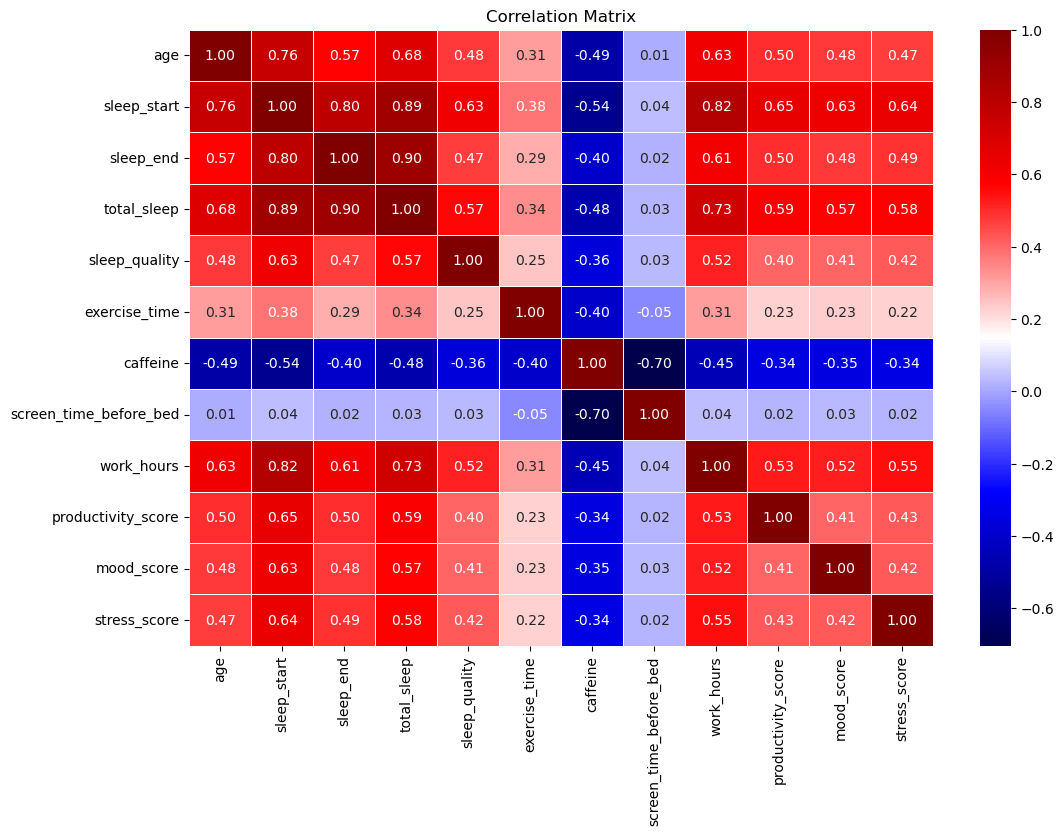

In [12]:
# to save column names
cols = data.drop(['id', 'date', 'gender'], axis=1).columns

# normalized dataset with assigning original columns back 
data_norm = pd.DataFrame(preprocessing.normalize(data.drop(['id', 'date', 'gender'], axis=1)), columns=cols)

# correlation matrix
corr_matrix = data_norm.corr()

# heatmap using seaborn
plt.figure(figsize=(12,8))
plt.title("Correlation Matrix")
sns.heatmap(corr_matrix, annot=True, fmt=".2f", linewidths=0.5, cmap='seismic')

plt.show()

<hr>

## Machine Learning

I chose `productivity_score` as the target feature because it is a <b>measurable outcome</b> influenced by various lifestyle factors like sleep, caffeine, and screen time. Predicting productivity provides actionable insights for users aiming to improve daily performance and habits. 

Also, I chose <b>RMSE as a perfomance metric</b> because it gives more weight to large errors, which helps highlight big mistakes in predicting productivity. It also uses the same units as the score, so it's easier to understand how far off the predictions are.

<hr>

### Data preprocessing

I will split data into train, validation and test datasets with 8:1:1 ratio

In [175]:
# dropping 'id' and 'date' columns
data = data.drop(['id', 'date'], axis=1)

# One-Hot Encoding (OHE)
data = pd.get_dummies(data, drop_first=True)

display(data.head())

,age,sleep_start,sleep_end,total_sleep,sleep_quality,exercise_time,caffeine,screen_time_before_bed,work_hours,productivity_score,mood_score,stress_score,gender_Male,gender_Other
0,32,23.33,4.61,5.28,3,86,87,116,8.808920,8,3,6,False,True
1,41,21.02,2.43,5.41,5,32,21,88,6.329833,10,3,7,False,False
2,20,22.10,3.45,5.35,7,17,88,59,8.506306,10,9,10,True,False
3,37,23.10,6.65,7.55,8,46,34,80,6.070240,8,4,2,False,True
4,46,21.42,4.17,6.75,10,61,269,94,11.374994,8,7,9,False,True


In [176]:
# data split
data_train, data_temp = train_test_split(data, test_size=0.2, shuffle=False)
data_valid, data_test = train_test_split(data_temp, test_size=0.5, shuffle=False)

In [177]:
# train: features and target
features_train = data_train.drop(['productivity_score'], axis=1)
target_train = data_train['productivity_score']

# valid: features and target
features_valid = data_valid.drop(['productivity_score'], axis=1)
target_valid = data_valid['productivity_score']

# test: features and target
features_test = data_test.drop(['productivity_score'], axis=1)
target_test = data_test['productivity_score']

I standartize datasets for Linear Regression model. <br>
Fitting scaler only on training set then transforming validation and test sets with it 

In [178]:
scaler = StandardScaler()

scaler.fit(features_train)
features_train_scaled = scaler.transform(features_train)
features_valid_scaled = scaler.transform(features_valid)
features_test_scaled = scaler.transform(features_test)

<hr>

### Linear Regression

Training time: less than a second <br>
RMSE: <b>2.951</b>

In [179]:
%%time

# Linear Regression model
model_linear = LinearRegression()

# training process
model_linear.fit(features_train_scaled, target_train)

CPU times: total: 0 ns
Wall time: 3 ms


LinearRegression()

In [180]:
# predicted target
pred_valid = model_linear.predict(features_valid_scaled)

# RMSE of model on validation set
display(mean_squared_error(target_valid, pred_valid, squared=False))

2.9518480571788084

<hr>

### LightGBM

Training time: 57s <br>
RMSE: <b>2.947</b>

In [181]:
%%time

# hyperparameter grid
param_grid = {
    'num_leaves': [31, 63],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [int(x) for x in np.linspace(10, 100, num = 5)],
    'max_depth': [int(x) for x in np.linspace(10, 50, num = 5)],
    'feature_fraction': [0.8, 1.0],
    'lambda_l1': [0, 0.5],
    'lambda_l2': [0, 0.5]
    }

# LGBMRegressor model
model_lgb = GridSearchCV(LGBMRegressor(random_state=42, verbose=-1), 
                         param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=3)

# training process
model_lgb.fit(features_train, target_train)

CPU times: total: 1min 41s
Wall time: 57.4 s


GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=42, verbose=-1),
             param_grid={'feature_fraction': [0.8, 1.0], 'lambda_l1': [0, 0.5],
                         'lambda_l2': [0, 0.5], 'learning_rate': [0.01, 0.1],
                         'max_depth': [10, 20, 30, 40, 50],
                         'n_estimators': [10, 32, 55, 77, 100],
                         'num_leaves': [31, 63]},
             scoring='neg_root_mean_squared_error')

In [182]:
# predicted target
pred_valid = model_lgb.predict(features_valid)

# RMSE of model on validation set
display(mean_squared_error(target_valid, pred_valid, squared=False))

2.9472592560124173

<hr>

### CatBoost

Training time: 6min 40s <br>
RMSE: <b>2.949</b>

In [183]:
%%time

# hyperparameters variations 
depth = [int(x) for x in np.linspace(2, 16, num = 3)]
loss_function = ['RMSE']
iterations = [int(x) for x in np.linspace(10, 100, num = 3)]
learning_rate = [0.01, 0.1]

# hyperparameter grid
param_grid = {'depth':depth,
              'loss_function':loss_function,
              'iterations':iterations,
              'learning_rate':learning_rate
             }

# CatBoostRegressor model
model_cat = GridSearchCV(CatBoostRegressor(), 
                         param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=3)

# training process 
model_cat.fit(features_train, target_train, verbose=False)

CPU times: total: 20min 57s
Wall time: 6min 40s


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000025AC559B650>,
             param_grid={'depth': [2, 9, 16], 'iterations': [10, 55, 100],
                         'learning_rate': [0.01, 0.1],
                         'loss_function': ['RMSE']},
             scoring='neg_root_mean_squared_error')

In [184]:
# predicted target
pred_valid = model_cat.predict(features_valid)

# RMSE of model on validation set
display(mean_squared_error(target_valid, pred_valid, squared=False))

2.9492071798815207

<hr>

## Results

From all three models I chose `LGBMRegressor` because it had the best <b>RMSE=2.947</b> and trained much faster than `CatBoost`. It also performed better than `Linear Regression`, making it the best balance between accuracy and speed

In [188]:
# df with models perfomance
models_stats = pd.DataFrame(data={'Training Time (s)':[57, 400, 1], 
                                  'RMSE':[2.947, 2.949, 2.951]}, 
                            index=['LGBMRegressor', 'CatBoostRegressor', 'LinearRegression'])
display(models_stats)

,Training Time (s),RMSE
LGBMRegressor,57,2.947
CatBoostRegressor,400,2.949
LinearRegression,1,2.951


### Dummy model

Model performed slightly above the level of a dummy baseline on the test dataset, indicating that the generated data lacks a meaningful relationship between features and target.

In [224]:
model_dummy = DummyRegressor(strategy='mean')

model_dummy.fit(features_train, target_train)

dummy_pred_test = model_dummy.predict(features_test)

display('dummy: ' + str(round(mean_squared_error(target_test, dummy_pred_test, squared=False), 4)))

'Dummy: 2.8619'

In [223]:
# predicted target
pred_test = model_lgb.predict(features_test)

# RMSE of model o
display('LGBM: ' + str(round(mean_squared_error(target_test, pred_test, squared=False), 4)))


'LGBM: 2.8617'

<hr>

## Feature Importance

The feature importance analysis from the best GridSearchCV model reveals that <b>`sleep_start` is the most influential predictor, followed by `exercise_time` and `screen_time_before_bed`</b>. These three features contribute significantly more than others, indicating a strong relationship with the target variable. <br>
In contrast, features like `gender_Male`, `gender_Other`, and `mood_score` had very low importance, suggesting minimal impact on the model’s predictions. This insight helps highlight which behavioral or lifestyle factors are most relevant in the context of the analysis.

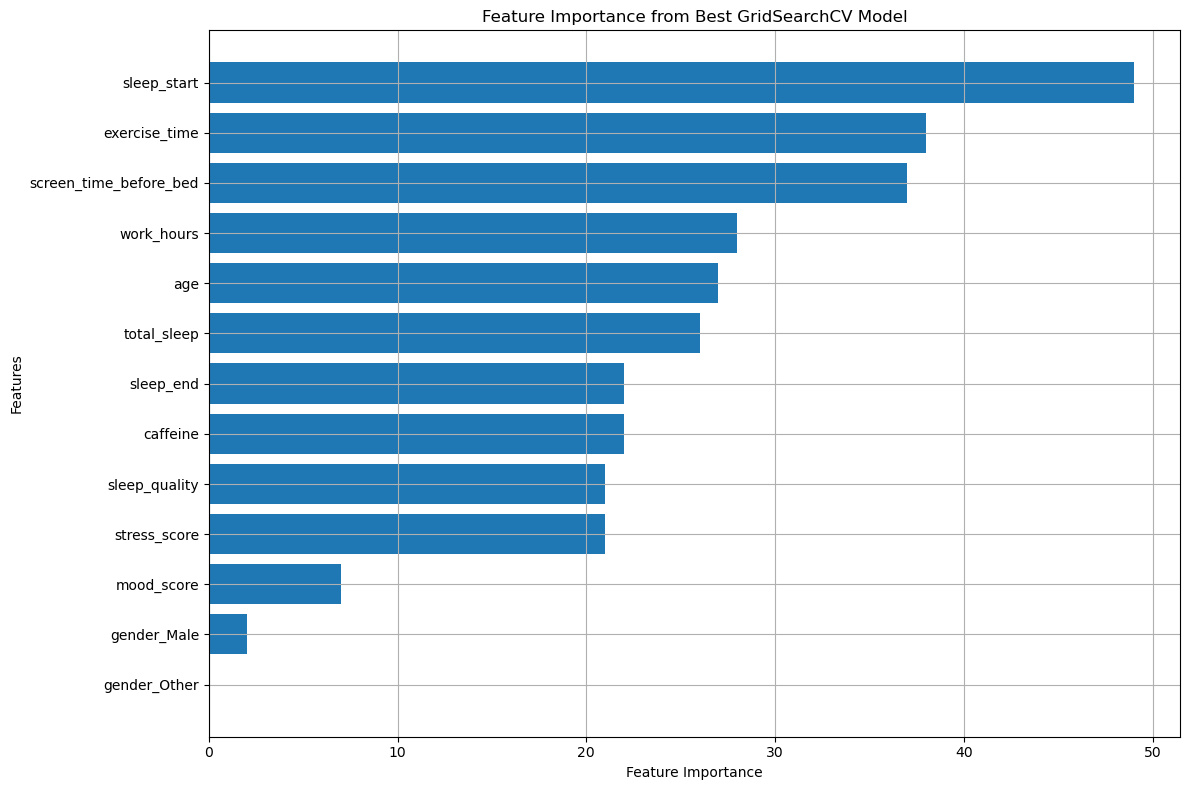

In [211]:
# best estimator
best_model = model_lgb.best_estimator_

# feature importances
importances = best_model.feature_importances_

# get feature names (if available)
feature_names = features_train.columns if isinstance(features_train, pd.DataFrame) else [f'Feature {i}' for i in range(len(importances))]

# df for plot
feat_imp = pd.DataFrame({'Feature': feature_names,
                         'Importance': importances
                        }).sort_values(by='Importance', ascending=False)

# bar plot
plt.figure(figsize=(12, 8))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance from Best GridSearchCV Model")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.grid()
plt.show()

<hr>

## Collected Data Analysis

In [38]:
real_data = pd.read_csv('collected_data.csv')

display(real_data)

,age,gender,sleep_start,sleep_end,sleep_quality,exercise_time,caffeine,screen_time_before_bed,work_hours,productivity_score,mood_score,stress_score
0,19,Female,23:00,10:06,9,10,190,3,4.0,7,8,3
1,21,Male,1:20,7:40,9,10,50,40,4.0,6,8,6
2,32,Male,23:11,7:00,7,180,60,20,5.0,7,8,7
3,21,Male,6:00,13:00,7,0,50,90,6.5,5,6,4
4,21,Female,2:00,10:00,6,10,50,40,3.0,3,6,4
5,22,Male,3:00,12:20,8,0,0,3,7.0,10,10,3
6,22,Male,0:00,9:00,10,0,0,60,8.0,10,10,10
7,21,Male,0:00,9:00,6,0,0,270,3.0,8,9,1
8,18,Female,21:30,6:10,8,0,230,3,8.0,8,6,6
9,30,Female,23:00,7:15,8,0,400,120,7.0,8,7,3


<hr>

### Preprocessing 

In [39]:
def time_to_float(t):
    h, m = map(int, t.split(':'))
    return round(h + m / 60, 2)

In [40]:
def compute_total_sleep(start, end):
    start = time_to_float(start)
    end = time_to_float(end)
    duration = end - start
    
    if duration < 0:
        duration += 24
    return round(duration, 2)

In [41]:
real_data['total_sleep'] = real_data.apply(lambda row: compute_total_sleep(row['sleep_start'], row['sleep_end']), axis=1)

real_data['sleep_start'] = real_data['sleep_start'].apply(time_to_float)
real_data['sleep_end'] = real_data['sleep_end'].apply(time_to_float)

<b>Performed once:</b>

`real_data.to_csv("collected_data_prepared.csv", index=False)`

In order to take a closer look using <b>Power BI</b>.